<a href="https://colab.research.google.com/github/Jia-wei-liao/NPDE_final_project/blob/main/DGM_Biharmonic2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jia-Wei, Liao (jw.sc09@nycu.edu.tw)
# Final Project of Numerical Methods for Partial Differential Equations 2021

In [2]:
import random, time, csv, os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input

# Set up the Neural Network

In [3]:
class Residual_block(tf.keras.Model):
  def __init__(self, n_Neural):
    super(Residual_block, self).__init__()
    self.Dense1 = Dense(n_Neural)
    self.Dense2 = Dense(n_Neural)
  
  def call(self, inputs):
    x = self.Dense1(inputs)
    x = tf.nn.sigmoid(x)
    x = self.Dense2(x)
    x = tf.nn.sigmoid(x)+x

    return x


class ResNet(tf.keras.Model):
  def __init__(self):
    super(ResNet, self).__init__()
    self.RB1 = Residual_block(100)
    self.RB2 = Residual_block(100)
    self.FinalLayer1 = Dense(1)
    self.FinalLayer2 = Dense(1)

    self.input_layer = Input(shape=(2))
    self.outputs = self.call(self.input_layer)

    super(ResNet, self).__init__(inputs=self.input_layer, outputs=self.outputs)
    
  def call(self, inputs, training=True):
    x = self.RB1(inputs)
    x = self.RB2(x)
    y = self.FinalLayer1(x)
    z = self.FinalLayer2(x)

    if training: return y, z
    else: return y

Model: "res_net_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
residual_block (Residual_block) (None, 100)          10400       input_1[0][0]                    
__________________________________________________________________________________________________
residual_block_1 (Residual_bloc (None, 100)          20200       residual_block[0][0]             
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            101         residual_block_1[0][0]           
__________________________________________________________________________________________

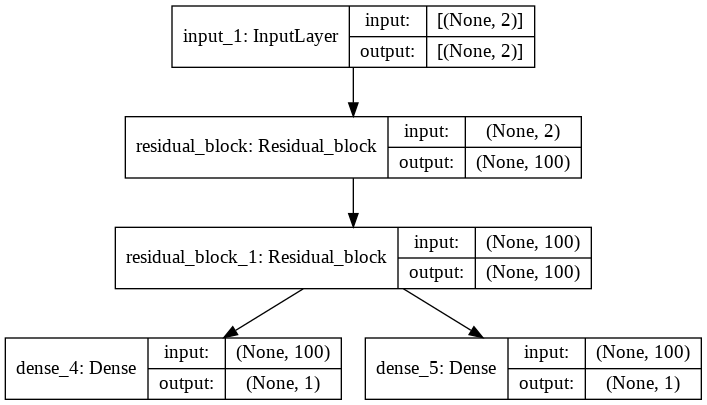

In [4]:
model = ResNet()
model.build((None, 2))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# Set the Parameter

In [5]:
epochs = 5000
alpha = 1
beta = 1
lr = 5e-4
optimizer = tf.keras.optimizers.Adam(lr)
mse = tf.keras.losses.MeanSquaredError()
N = 100  # number of interior sample point
M = 30  # number of boundary sample point

test_period = 500
save_period = 1000
save_weight = False
save_loss = False
weight_path = 'DGM_Biharmonic2DWeight'

if not os.path.isdir(weight_path):
  os.makedirs(weight_path)

# Define the function and exact solution

In [6]:
def f(X):
  x, y = X[:, 0], X[:, 1]
  return (np.sin(np.pi*y) - 2*np.pi**2 * np.sin(np.pi*y) + np.pi**4 * np.sin(np.pi*y))*np.e**x

def ux(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x * np.sin(np.pi*y)

def uy(X):
  x, y = X[:, 0], X[:, 1]
  return np.pi * np.e**x * np.cos(np.pi*y)

def u_exact(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x * np.sin(np.pi*y)

In [7]:
def generate_interior_point(num):
  sample = tf.random.uniform((num,2), minval=0, maxval=1, dtype=tf.dtypes.float32)
  return sample


def generate_boundary_point(num):
  left = np.random.rand(num,1)
  right = np.random.randint(0, 2, (num,1))
  random = np.concatenate([left, right], axis=1)
  change = np.random.choice(a=[True, False], size=(num))
  random[change, 0], random[change, 1] = random[change, 1], random[change, 0]
  random = tf.constant(random, dtype=tf.float32)
  return random


def BdyLoss(X, model, u_exact):
  U = model(X)[0]
  u = u_exact(X)
  return mse(U, u)


def GradLoss(X, model, ux, uy):
  Xleft, Xright = X[X[:,0]==0], X[X[:,0]==1]
  Xdown, Xup = X[X[:,1]==0], X[X[:,1]==1]

  Duleft, Duright = ux(Xleft), ux(Xright)
  Dudown, Duup = uy(Xdown), uy(Xup)

  with tf.GradientTape() as t:
    t.watch(X)
    U = model(X)[0]
  DU = t.gradient(U, X)
  DUleft, DUright = DU[X[:,0]==0][:,0], DU[X[:,0]==1][:,0]
  DUdown, DUup = DU[X[:,1]==0][:,1], DU[X[:,1]==1][:,1]

  total_loss = 0
  if Duleft.shape[0]>0:
    total_loss += mse(Duleft, DUleft)
  if Duright.shape[0]>0:
    total_loss += mse(Duright, DUright)
  if Dudown.shape[0]>0:
    total_loss += mse(Dudown, DUdown)
  if Duup.shape[0]>0:
    total_loss += mse(Duup, DUup)

  return total_loss/X.shape[0]


def get_MeanLoss(List, keys):
  result = {}
  for key in keys:
    result[key] = np.mean([e[key] for e in List])
    
  return result


def save_csv(file_name, dict_list, key_list):
  with open(file_name, 'w', newline ='') as f:
    writer = csv.DictWriter(f, fieldnames = key_list)
    writer.writeheader()
    writer.writerows(dict_list)

# Training function

In [8]:
def Training(model, N, M, Loss_list, tic):
  with tf.GradientTape() as t5:
    X, Xb = generate_interior_point(N), generate_boundary_point(M)
    with tf.GradientTape() as t4, tf.GradientTape() as t3:
      t3.watch(X)
      t4.watch(X)
      with tf.GradientTape() as t2, tf.GradientTape() as t1:
        t1.watch(X)
        t2.watch(X)
        
        U, P = model(X)

      DU, DP = t1.gradient(U, X), t2.gradient(P, X)
    DDU, DDP = t3.gradient(DU, X), t4.gradient(DP, X)
    LU, LP = tf.reduce_sum(DDU, 1), tf.reduce_sum(DDP, 1)
    F = f(X)

    # Compute loss
    loss1 = mse(LU, P)/N
    loss2 = mse(LP, F)/N
    bdyloss = BdyLoss(Xb, model, u_exact)/M
    gradloss = GradLoss(Xb, model, ux, uy)/M
    loss = loss1 + loss2 + bdyloss*alpha + gradloss*beta
    Loss_list.append({'InteriorLoss': loss1.numpy()+loss2.numpy(), 'BoundaryLoss': bdyloss.numpy(), 'GradLoss': gradloss.numpy(), 'TotalLoss': loss.numpy()})

    # Compute gradient
    grads = t5.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Print the information
    if ep % 100 == 1:
      print(f"Epoch: {ep}, Time: {time.time()-tic:.0f}, "\
      f"InteriorLoss: {loss1+loss2:.8f}, "\
      f"BoundaryLoss: {bdyloss:.8f}, "\
      f"GradLoss: {gradloss:.8f}, "\
      f"TotalLoss: {loss:.8f}")

# Testing function

In [9]:
def PlotMesh(x, y, u, title):
  u = u[:-1, :-1]
  levels = MaxNLocator(nbins=15).tick_values(u.min(), u.max())
  cmap = plt.get_cmap('YlGnBu')
  im = plt.pcolormesh(x, y, u, cmap=cmap)
  plt.colorbar(im)
  plt.title(title)


def PointwiseError(U, u, method):
  if method == 'abs':
    return abs(U-u)
  
  if method == 'relative':
    return abs(U-u)/abs(u+1e-8)


def compute_error(U, u, method):
  abs_error = abs(U-u)

  if method == 'InfNorm':
    return np.max(abs_error)

  if method == 'TwoNorm':
    return np.sqrt(np.mean(abs_error**2))

  if method == 'Relative':
    return np.sqrt(np.mean(abs_error**2))/np.sqrt(np.mean(u**2))


def Testing(x, y, model):
  [xx, yy] = np.meshgrid(x, y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  X = np.hstack([xx,yy])

  U = np.array(model(X, training=False)).reshape(100,100)
  u = u_exact(X).reshape(100,100)
  abs_error = PointwiseError(U, u, 'abs')
  relative_error = PointwiseError(U, u, 'relative')

  plt.figure(figsize=(10,8))
  plt.subplot(2,2,1)
  PlotMesh(x, y, U, 'DNN')
  plt.subplot(2,2,2)
  PlotMesh(x, y, u, 'exact')
  plt.subplot(2,2,3)
  PlotMesh(x[1:99], y[1:99], abs_error[1:99, 1:99], 'error')
  plt.subplot(2,2,4)
  PlotMesh(x[1:99], y[1:99], relative_error[1:99, 1:99], 'relative error')
  plt.show()
  
  Inf = compute_error(U, u, 'InfNorm')
  Two = compute_error(U, u, 'TwoNorm')
  Relative = compute_error(U, u, 'Relative')
  print(f'InfNorm: {Inf:.8f}, TwoNorm: {Two:.8f}, Relative: {Relative:.8f}')


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

Epoch: 1, Time: 2, InteriorLoss: 113.49993896, BoundaryLoss: 0.16651890, GradLoss: 0.04862561, TotalLoss: 113.71508026
Epoch: 101, Time: 15, InteriorLoss: 18.08153725, BoundaryLoss: 0.03767883, GradLoss: 0.05208653, TotalLoss: 18.17130280
Epoch: 201, Time: 27, InteriorLoss: 18.47122574, BoundaryLoss: 0.01972839, GradLoss: 0.04503582, TotalLoss: 18.53598976
Epoch: 301, Time: 40, InteriorLoss: 18.77858734, BoundaryLoss: 0.02673101, GradLoss: 0.05666727, TotalLoss: 18.86198616
Epoch: 401, Time: 52, InteriorLoss: 13.31262398, BoundaryLoss: 0.01698783, GradLoss: 0.04764434, TotalLoss: 13.37725639


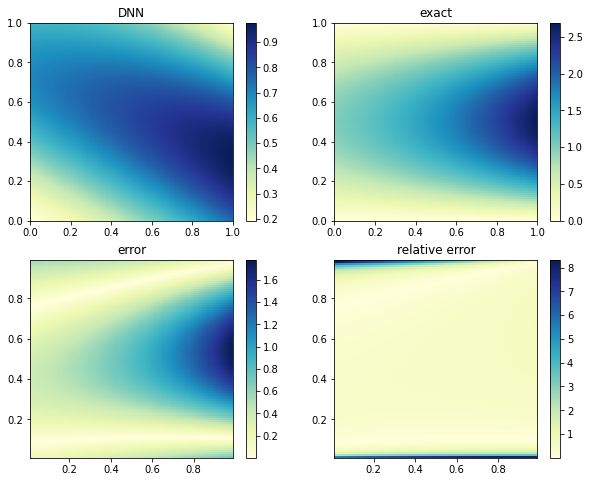

InfNorm: 1.83607664, TwoNorm: 0.66460343, Relative: 0.52768002
Epoch: 501, Time: 65, InteriorLoss: 6.98865271, BoundaryLoss: 0.01763893, GradLoss: 0.05027432, TotalLoss: 7.05656624
Epoch: 601, Time: 78, InteriorLoss: 1.69144166, BoundaryLoss: 0.01173540, GradLoss: 0.03691405, TotalLoss: 1.74009109
Epoch: 701, Time: 90, InteriorLoss: 0.78440231, BoundaryLoss: 0.00970085, GradLoss: 0.02726229, TotalLoss: 0.82136542
Epoch: 801, Time: 102, InteriorLoss: 0.49625614, BoundaryLoss: 0.01348740, GradLoss: 0.02346495, TotalLoss: 0.53320849
Epoch: 901, Time: 114, InteriorLoss: 0.33539069, BoundaryLoss: 0.00648159, GradLoss: 0.01738125, TotalLoss: 0.35925353


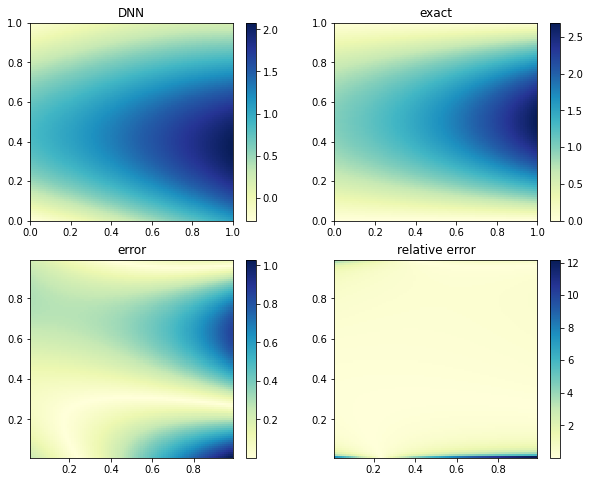

InfNorm: 1.09598851, TwoNorm: 0.32948649, Relative: 0.26160478
Epoch: 1001, Time: 128, InteriorLoss: 0.25012350, BoundaryLoss: 0.00691019, GradLoss: 0.01302408, TotalLoss: 0.27005777
Epoch: 1101, Time: 140, InteriorLoss: 0.09648491, BoundaryLoss: 0.00776814, GradLoss: 0.01141012, TotalLoss: 0.11566316
Epoch: 1201, Time: 152, InteriorLoss: 0.10475883, BoundaryLoss: 0.00747762, GradLoss: 0.01052575, TotalLoss: 0.12276220
Epoch: 1301, Time: 165, InteriorLoss: 0.18013863, BoundaryLoss: 0.00420015, GradLoss: 0.01092881, TotalLoss: 0.19526759
Epoch: 1401, Time: 177, InteriorLoss: 0.06173832, BoundaryLoss: 0.00475624, GradLoss: 0.01639747, TotalLoss: 0.08289202


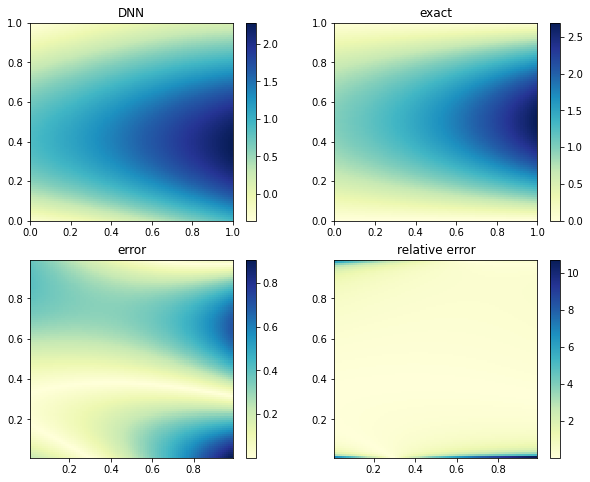

InfNorm: 0.95602244, TwoNorm: 0.30305293, Relative: 0.24061714
Epoch: 1501, Time: 190, InteriorLoss: 0.03754964, BoundaryLoss: 0.00357499, GradLoss: 0.00853052, TotalLoss: 0.04965515
Epoch: 1601, Time: 203, InteriorLoss: 0.02695610, BoundaryLoss: 0.00366540, GradLoss: 0.01485243, TotalLoss: 0.04547393
Epoch: 1701, Time: 215, InteriorLoss: 0.02624259, BoundaryLoss: 0.00501866, GradLoss: 0.01241191, TotalLoss: 0.04367315
Epoch: 1801, Time: 227, InteriorLoss: 0.03349510, BoundaryLoss: 0.00321490, GradLoss: 0.01009037, TotalLoss: 0.04680036
Epoch: 1901, Time: 239, InteriorLoss: 0.02240592, BoundaryLoss: 0.00513589, GradLoss: 0.00742875, TotalLoss: 0.03497056


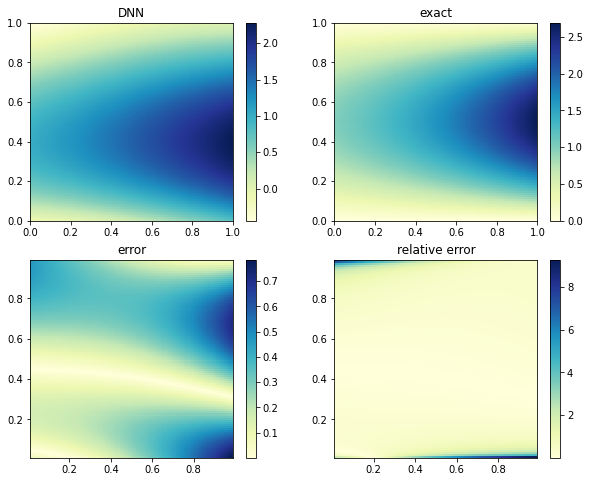

InfNorm: 0.82436520, TwoNorm: 0.31160909, Relative: 0.24741054
Epoch: 2001, Time: 253, InteriorLoss: 0.02101275, BoundaryLoss: 0.00385872, GradLoss: 0.00916801, TotalLoss: 0.03403948
Epoch: 2101, Time: 265, InteriorLoss: 0.01579644, BoundaryLoss: 0.00375567, GradLoss: 0.01101759, TotalLoss: 0.03056970
Epoch: 2201, Time: 277, InteriorLoss: 0.01358317, BoundaryLoss: 0.00256067, GradLoss: 0.00915346, TotalLoss: 0.02529730
Epoch: 2301, Time: 290, InteriorLoss: 0.01231173, BoundaryLoss: 0.00397986, GradLoss: 0.01135330, TotalLoss: 0.02764489
Epoch: 2401, Time: 302, InteriorLoss: 0.00948209, BoundaryLoss: 0.00458173, GradLoss: 0.00401292, TotalLoss: 0.01807673


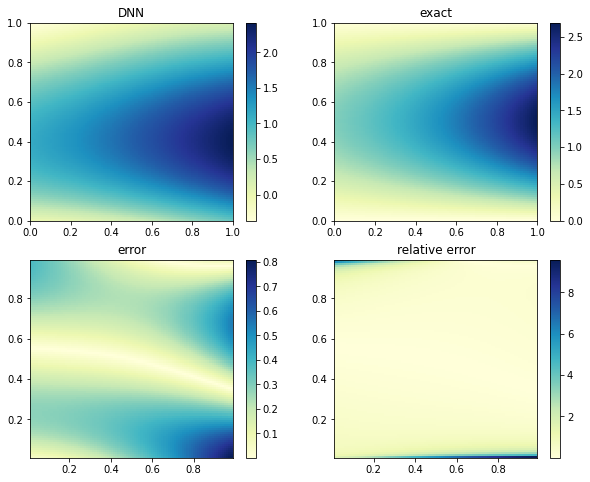

InfNorm: 0.84343165, TwoNorm: 0.28249520, Relative: 0.22429477
Epoch: 2501, Time: 315, InteriorLoss: 0.01591831, BoundaryLoss: 0.00433946, GradLoss: 0.00751246, TotalLoss: 0.02777022
Epoch: 2601, Time: 328, InteriorLoss: 0.01270415, BoundaryLoss: 0.00285456, GradLoss: 0.00961953, TotalLoss: 0.02517824
Epoch: 2701, Time: 340, InteriorLoss: 0.02868820, BoundaryLoss: 0.00410885, GradLoss: 0.00614137, TotalLoss: 0.03893841
Epoch: 2801, Time: 352, InteriorLoss: 0.01503795, BoundaryLoss: 0.00138401, GradLoss: 0.00769011, TotalLoss: 0.02411207
Epoch: 2901, Time: 365, InteriorLoss: 0.00913674, BoundaryLoss: 0.00271381, GradLoss: 0.00788181, TotalLoss: 0.01973236


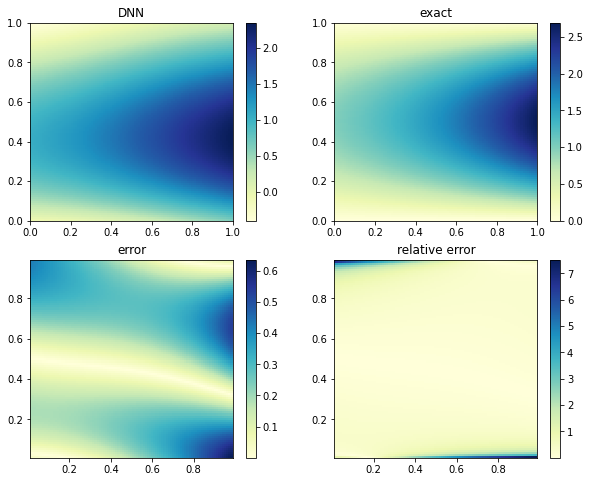

InfNorm: 0.66492426, TwoNorm: 0.25290753, Relative: 0.20080283
Epoch: 3001, Time: 378, InteriorLoss: 0.02769844, BoundaryLoss: 0.00232625, GradLoss: 0.00746164, TotalLoss: 0.03748634
Epoch: 3101, Time: 391, InteriorLoss: 0.00662024, BoundaryLoss: 0.00303547, GradLoss: 0.00500463, TotalLoss: 0.01466034
Epoch: 3201, Time: 403, InteriorLoss: 0.01186194, BoundaryLoss: 0.00295987, GradLoss: 0.00548745, TotalLoss: 0.02030926
Epoch: 3301, Time: 416, InteriorLoss: 0.00762568, BoundaryLoss: 0.00335660, GradLoss: 0.00430552, TotalLoss: 0.01528779
Epoch: 3401, Time: 428, InteriorLoss: 0.00427554, BoundaryLoss: 0.00269470, GradLoss: 0.00568807, TotalLoss: 0.01265831


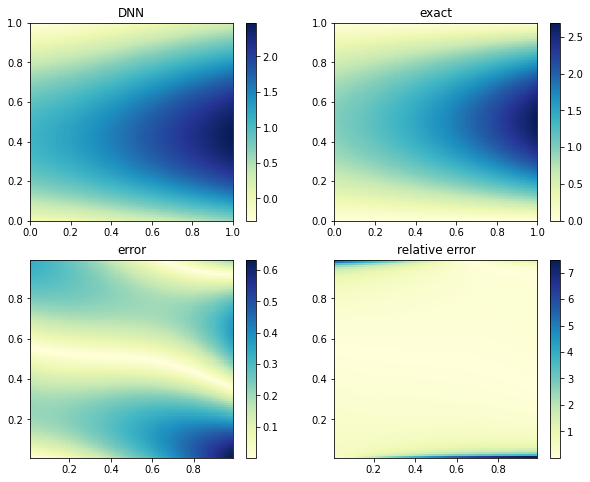

InfNorm: 0.65698951, TwoNorm: 0.22905674, Relative: 0.18186585
Epoch: 3501, Time: 441, InteriorLoss: 0.00864517, BoundaryLoss: 0.00244863, GradLoss: 0.00487633, TotalLoss: 0.01597012
Epoch: 3601, Time: 454, InteriorLoss: 0.00457976, BoundaryLoss: 0.00221781, GradLoss: 0.00922487, TotalLoss: 0.01602244
Epoch: 3701, Time: 466, InteriorLoss: 0.00479227, BoundaryLoss: 0.00201270, GradLoss: 0.00618504, TotalLoss: 0.01299001
Epoch: 3801, Time: 478, InteriorLoss: 0.01954868, BoundaryLoss: 0.00192345, GradLoss: 0.00410819, TotalLoss: 0.02558032
Epoch: 3901, Time: 490, InteriorLoss: 0.00689898, BoundaryLoss: 0.00141095, GradLoss: 0.00495629, TotalLoss: 0.01326622


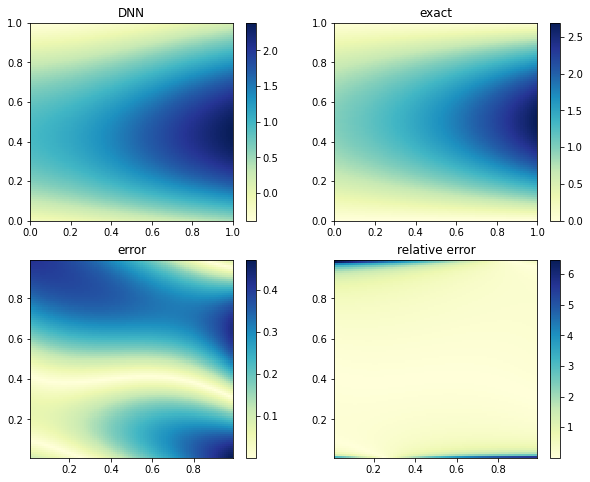

InfNorm: 0.49111494, TwoNorm: 0.24114159, Relative: 0.19146095
Epoch: 4001, Time: 504, InteriorLoss: 0.00559480, BoundaryLoss: 0.00216747, GradLoss: 0.00674360, TotalLoss: 0.01450588
Epoch: 4101, Time: 516, InteriorLoss: 0.00863097, BoundaryLoss: 0.00237781, GradLoss: 0.00559421, TotalLoss: 0.01660299
Epoch: 4201, Time: 528, InteriorLoss: 0.02635475, BoundaryLoss: 0.00184544, GradLoss: 0.00313533, TotalLoss: 0.03133552
Epoch: 4301, Time: 541, InteriorLoss: 0.00623813, BoundaryLoss: 0.00127969, GradLoss: 0.00589905, TotalLoss: 0.01341687
Epoch: 4401, Time: 553, InteriorLoss: 0.01790844, BoundaryLoss: 0.00188439, GradLoss: 0.00402258, TotalLoss: 0.02381541


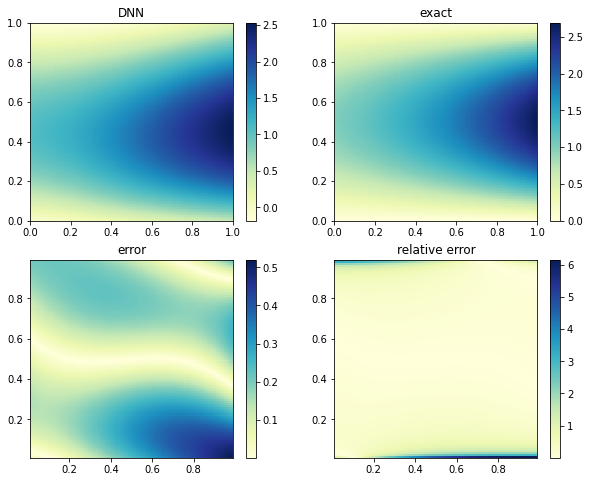

InfNorm: 0.53458208, TwoNorm: 0.20108800, Relative: 0.15965930
Epoch: 4501, Time: 566, InteriorLoss: 0.00862509, BoundaryLoss: 0.00183319, GradLoss: 0.00353983, TotalLoss: 0.01399811
Epoch: 4601, Time: 579, InteriorLoss: 0.00393052, BoundaryLoss: 0.00158726, GradLoss: 0.00437092, TotalLoss: 0.00988870
Epoch: 4701, Time: 591, InteriorLoss: 0.00446610, BoundaryLoss: 0.00086414, GradLoss: 0.00417246, TotalLoss: 0.00950270
Epoch: 4801, Time: 604, InteriorLoss: 0.03882457, BoundaryLoss: 0.00191829, GradLoss: 0.00400993, TotalLoss: 0.04475280
Epoch: 4901, Time: 616, InteriorLoss: 0.01890198, BoundaryLoss: 0.00218240, GradLoss: 0.00219327, TotalLoss: 0.02327764


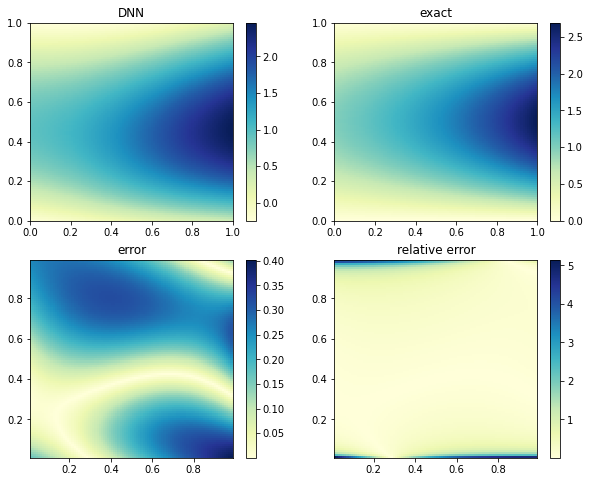

InfNorm: 0.41492525, TwoNorm: 0.20394568, Relative: 0.16192824


In [10]:
Loss_list = []
tic = time.time()

for ep in range(1, epochs+1):
  Training(model, N, M, Loss_list, tic)
  if ep % test_period ==0:
    Testing(x, y, model)

  # Save weight
  if save_weight and (ep==1 or ep % save_period ==0):
    filename = f'DGM_Biharmonic2DWeight_{ep}_{N}_{M}_{lr:.0e}'
    save_path = os.path.join(weight_path, filename + '.h5')
    model.save_weights(save_path)

# Save information

In [11]:
if save_loss:
  filename = f'DGM_Biharmonic2DWeight_{epochs}_{N}_{M}_{lr:.0e}'
  save_csv(filename+'.csv', Loss_list, ['InteriorLoss', 'BoundaryLoss', 'GradLoss', 'TotalLoss'])